In [ ]:
#category recognition 透過學習已知服裝圖片與標籤，可訓練出model用來辨識其他未知服飾圖片的服裝類別category

In [1]:
from fastai.vision.data import ImageDataLoaders
from fastai.vision.all import *
from fastai.imports import *
from fastai.data.all import *
from fastai.optimizer import *
from fastai.callback.core import *
import fastai
import gc 
import pandas as pd
import os
from PIL import Image
import torch
import matplotlib.pyplot as plt


%matplotlib inline

PATH = 'C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/'
TRAINING_PATH = "C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/case_train.csv"
TEST_PATH = "C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/case_test.csv"
CLASSES_PATH = "C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/class_case.txt"

In [ ]:
#建立fastai data block

In [2]:
data = ImageDataLoaders.from_csv(PATH, csv_fname=TRAINING_PATH,
                                 item_tfms=Resize(300),
                                 batch_tfms=aug_transforms(size=224, min_scale=0.9),
                                 valid_pct=0.1,
                                 bs=96,
                                 splitter=RandomSplitter(seed=42), #seed=42
                                 num_workers=0)
data=data.to('cuda:0')
print(data.device)

cuda:0


In [3]:
train_df = pd.read_csv(TRAINING_PATH)
train_df.head(5)

,image_name,category_name
0,user1/task_09/img_00019069.jpg,Tank
1,user1/task_09/img_00019073.jpg,Shirt
2,user1/task_09/img_00019077.jpg,Long Sleeve Top
3,user1/task_09/img_00019085.jpg,Short Sleeve Top
4,user1/task_09/img_00019165.jpg,Dress


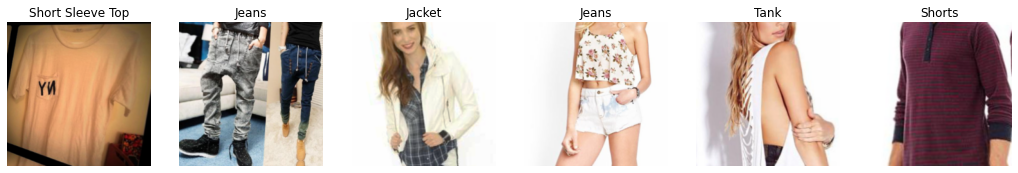

In [5]:
data.show_batch(max_n=6, nrows=1)

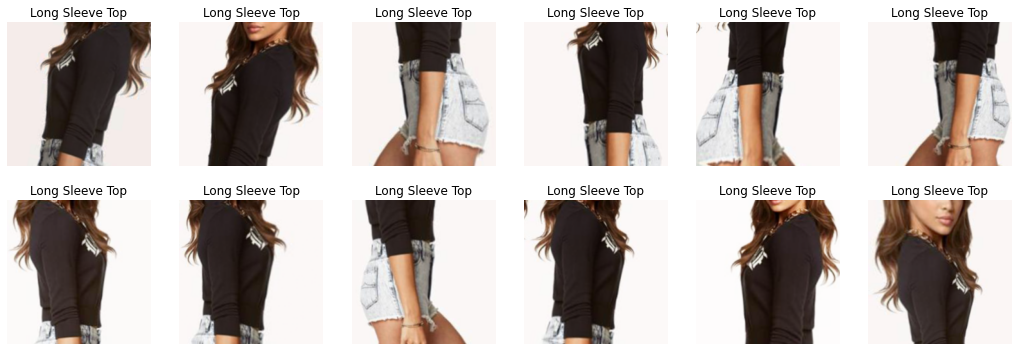

In [8]:
data.show_batch(max_n=12, nrows=2, unique=True)

# 訓練

In [9]:
learn = cnn_learner(data, resnet34,loss_func=CrossEntropyLossFlat(), metrics=accuracy, pretrained=True)

In [10]:
learn.fine_tune(2)
learn.save('stage-1')

epoch,train_loss,valid_loss,accuracy,time
0,1.718008,1.376063,0.566919,12:03


epoch,train_loss,valid_loss,accuracy,time
0,1.177702,0.993279,0.685474,09:54
1,0.976534,0.880433,0.723258,09:53


Path('C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/models/stage-1.pth')

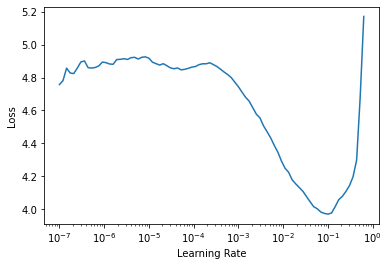

In [15]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
lr_min, lr_steep = learn.lr_find()

In [16]:
print(f"Minimum/10: {lr_min: .2e}, steepest point: {lr_steep: .2e}")

Minimum/10:  1.00e-02, steepest point:  7.59e-03


In [17]:
learn.fine_tune(2, base_lr=5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.614193,1.323674,0.580688,08:30


epoch,train_loss,valid_loss,accuracy,time
0,1.183775,1.072546,0.672376,09:56
1,0.896882,0.849380,0.724937,09:54


In [18]:
learn.save('stage-2')

Path('C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/models/stage-2.pth')

In [5]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
learn = learn.load(file='C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/models/stage-2') 

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=9.12010818865383e-07)

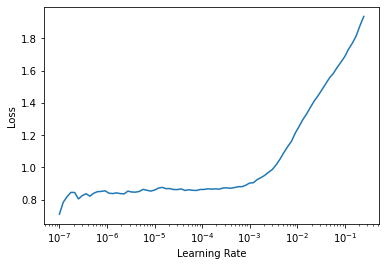

In [6]:
learn.unfreeze()
learn.lr_find()

In [8]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-4))


epoch,train_loss,valid_loss,accuracy,time
0,0.841467,0.725551,0.766919,10:00
1,0.838513,0.717960,0.767254,07:43
2,0.820932,0.710489,0.768766,07:43
3,0.821901,0.711144,0.765911,07:39
4,0.788347,0.706989,0.771285,08:29
5,0.810078,0.709327,0.769102,07:42


In [10]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-4))
learn.save('stage-3')

epoch,train_loss,valid_loss,accuracy,time
0,0.791969,0.707528,0.768766,07:42
1,0.794679,0.709050,0.769437,07:43
2,0.787904,0.703485,0.772964,07:52
3,0.767742,0.700667,0.774979,10:00
4,0.776126,0.701607,0.774307,08:30
5,0.780005,0.700487,0.775315,08:20


Path('C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/models/stage-3.pth')

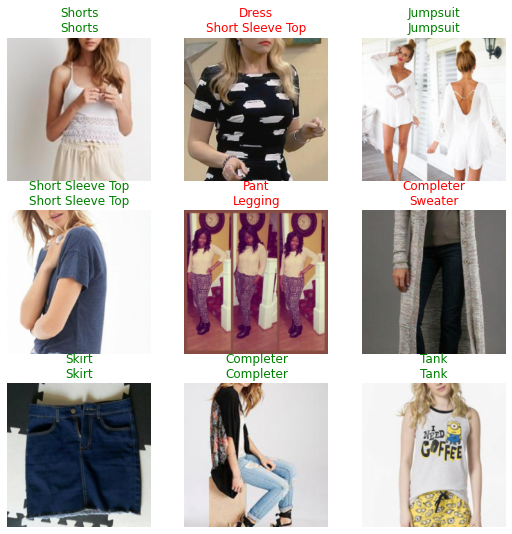

In [11]:
learn.show_results()

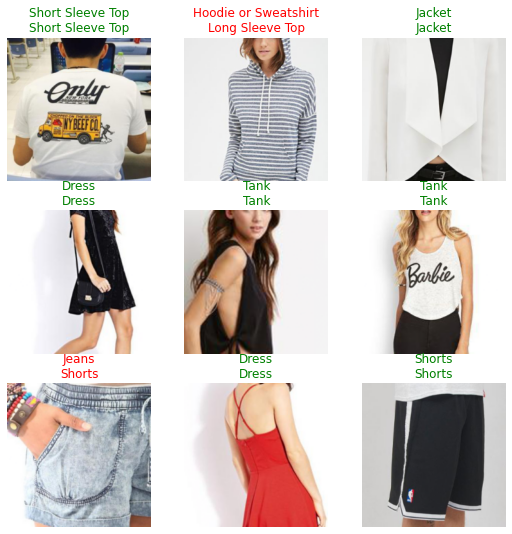

In [14]:
learn.show_results()

SuggestedLRs(lr_min=4.78630090583465e-07, lr_steep=1.0964781722577754e-06)

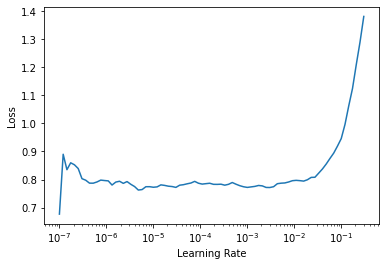

In [6]:
learn.lr_find()

In [7]:
learn.fit_one_cycle(6, lr_max=slice(1e-7, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.759555,0.600898,0.802855,06:55
1,0.799574,0.602939,0.802183,06:59
2,0.771273,0.602876,0.799160,09:27
3,0.756655,0.601834,0.800336,09:45
4,0.751035,0.602665,0.799496,08:10
5,0.767461,0.602087,0.798824,06:39


In [8]:
learn.save('stage-4')

Path('C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/models/stage-4.pth')

In [3]:
learn = cnn_learner(data, resnet34, metrics=accuracy)
learn = learn.load(file='C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/models/stage-4')

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=3.630780702224001e-05)

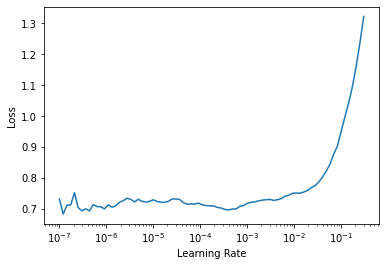

In [6]:
learn.lr_find()

In [18]:
modelname = learn.model
modelname.cpu()
torch.save(modelname, 'C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/models/stage-4_resnet34.pkl')

with open(CLASSES_PATH, 'w') as f:
    for item in data.vocab:
        f.write("%s\n" % item)

# 測試TEST

Top 1

In [4]:
test_img_data = ImageDataLoaders.from_csv(PATH, csv_fname=TEST_PATH,
                                 item_tfms=Resize(224), 
                                 #batch_tfms=Normalize.from_stats(*imagenet_stats),
                                 num_workers=0)

In [5]:
learn.data = test_img_data
learn.validate()

(#2) [0.6384326815605164,0.7961376905441284]

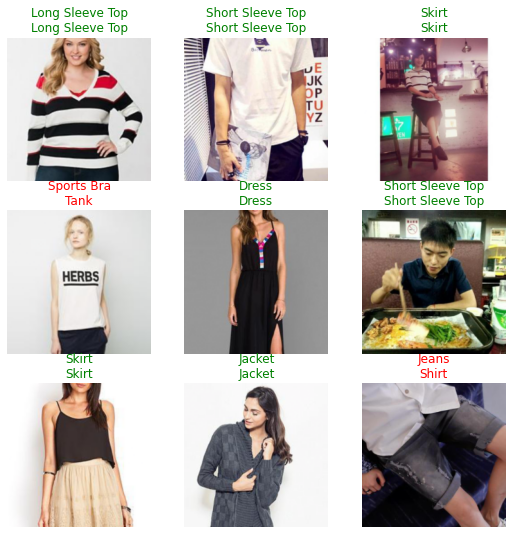

In [7]:
learn.show_results()

Top 3

In [5]:
def accuracy_topk(output, target, topk=(3,)):
    """Computes the accuracy for the specified values of k"""

    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        #print(correct[:k].contiguous().view(-1))
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [6]:
output, target = learn.get_preds()
print(accuracy_topk(output=output, target=target))

[TensorCategory([95.8018])]


# 測試整體

In [8]:
CASE_PATH = 'C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/cvat_pictures/'
CASE_TEST_PATH = 'C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/case_test.csv'
class_dic = pd.read_csv(
    'C:/Users/Alan/Desktop/fashion_classification/case_data/my-mongo/class_case.txt', sep="\n",header=None)

In [9]:
test_dict = {}
reader = csv.DictReader(open(CASE_TEST_PATH))
#reader.next()
for row in reader:
    test_dict[row["image_name"]] = row["category_name"]

In [18]:
size = 224,224
classified_list = []
topk=3
uplimit=0.85
dlimit= 0.2
count=0
not_count=0
one_class=0
two_class=0
three_class = 0
for key, value in test_dict.items():
    count= count + 1
    outputs = learn.predict(CASE_PATH + key)[2]
    top_conf, i = outputs.topk(topk)
    
    predicted1 = class_dic[0][i.tolist()[0]]
    predicted2 = class_dic[0][i.tolist()[1]]
    predicted3 = class_dic[0][i.tolist()[2]]
    if top_conf.tolist()[0] > uplimit:
        if predicted1 == value:
            classified_list.append(1)
            one_class += 1
    elif top_conf.tolist()[1] > dlimit:
        if predicted1 == value or predicted2 == value:
            classified_list.append(1)
            two_class += 1
            
    elif top_conf.tolist()[2] > dlimit:
        if predicted1 == value or predicted2 == value or predicted3 == value:
            classified_list.append(1)
            three_class += 1

    else:
        not_count = not_count+1
    if count== 1000:
        break
             
print(not_count, one_class, two_class, three_class)
print("Accuracy :", len(classified_list)/(count-not_count))

223 509 196 0
Accuracy : 0.9073359073359073
